# Part C – Programming Task (Python / Jupyter Notebook)
1. Implement A* search on a maze (given as a 2D matrix where 1=wall, 0=path, A=start,
B=goal).
- Use Manhattan distance as heuristic.
- Visualize the path found.
2. Modify the heuristic:
 - Case 1: Multiply Manhattan distance by 1.5 (check if it is admissible).
 - Case 2: Define heuristic so that for one edge it violates consistency.
3. For each case, run A* and record:
- Path found
- Cost of path
- Whether the path is optimal


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
from matplotlib.patches import Patch

class AStarMazeSolver:
    """Reusable A* Maze Solver with different heuristic options"""
    
    def __init__(self, maze):
        self.maze = maze
        self.start, self.goal = self._find_start_goal()
        self.optimal_cost = None  # Will be set after first run
    
    def _find_start_goal(self):
        start = goal = None
        for i in range(len(self.maze)):
            for j in range(len(self.maze[0])):
                if self.maze[i][j] == 'A':
                    start = (i, j)
                elif self.maze[i][j] == 'B':
                    goal = (i, j)
        return start, goal
    
    def _get_neighbors(self, pos):
        row, col = pos
        neighbors = []
        rows, cols = len(self.maze), len(self.maze[0])
        for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
            nr, nc = row + dr, col + dc
            if 0 <= nr < rows and 0 <= nc < cols and self.maze[nr][nc] != 1:
                neighbors.append((nr, nc))
        return neighbors
    
    def _reconstruct_path(self, came_from, current):
        path = [current]
        while current in came_from:
            current = came_from[current]
            path.append(current)
        return path[::-1]
    
    def manhattan_distance(self, pos1, pos2):
        return abs(pos1[0]-pos2[0]) + abs(pos1[1]-pos2[1])
    
    def heuristic_case1(self, pos1, pos2):
        return 1.5 * self.manhattan_distance(pos1, pos2)
    
    def heuristic_case2(self, pos1, pos2):
        base_h = self.manhattan_distance(pos1, pos2)
        if pos1 == (3, 1):  # force inconsistency
            return base_h + 3
        return base_h
    
    def search(self, heuristic_name='manhattan'):
        heuristic_map = {
            'manhattan': self.manhattan_distance,
            'case1': self.heuristic_case1,
            'case2': self.heuristic_case2
        }
        if heuristic_name not in heuristic_map:
            return {'path_found': False, 'error': 'Unknown heuristic'}
        
        heuristic_func = heuristic_map[heuristic_name]
        open_set = [(0, 0, self.start)]
        came_from = {}
        g_score = {self.start: 0}
        visited_order = []
        
        while open_set:
            f, g, current = heapq.heappop(open_set)
            if current in visited_order:
                continue
            visited_order.append(current)
            
            if current == self.goal:
                path = self._reconstruct_path(came_from, current)
                cost = g_score[current]
                if self.optimal_cost is None and heuristic_name == 'manhattan':
                    self.optimal_cost = cost
                return {
                    'path_found': True,
                    'path': path,
                    'cost_of_path': cost,
                    'path_is_optimal': cost == self.optimal_cost if self.optimal_cost else True,
                    'nodes_visited': len(visited_order),
                    'heuristic_used': heuristic_name,
                    'visited_order': visited_order
                }
            
            for nb in self._get_neighbors(current):
                if nb in visited_order:
                    continue
                new_g = g_score[current] + 1
                if nb not in g_score or new_g < g_score[nb]:
                    came_from[nb] = current
                    g_score[nb] = new_g
                    heapq.heappush(open_set, (new_g + heuristic_func(nb, self.goal), new_g, nb))
        
        return {
            'path_found': False,
            'cost_of_path': float('inf'),
            'path_is_optimal': False,
            'nodes_visited': len(visited_order),
            'heuristic_used': heuristic_name,
            'visited_order': visited_order 
        }
    
    def test_admissibility(self, heuristic_name):
        heuristic_map = {
            'manhattan': self.manhattan_distance,
            'case1': self.heuristic_case1,
            'case2': self.heuristic_case2
        }
        heuristic_func = heuristic_map[heuristic_name]
        true_distances = {}
        queue = [(self.goal, 0)]
        visited = {self.goal}
        while queue:
            pos, dist = queue.pop(0)
            true_distances[pos] = dist
            for nb in self._get_neighbors(pos):
                if nb not in visited:
                    visited.add(nb)
                    queue.append((nb, dist+1))
        
        violations = []
        for pos, true_d in true_distances.items():
            h = heuristic_func(pos, self.goal)
            if h > true_d:
                violations.append((pos, h, true_d))
        return len(violations) == 0, violations
    
    def visualize(self, result, title_suffix=""):
        path = result['path'] if result['path_found'] else None
        visited = result.get('visited_order', [])
        rows, cols = len(self.maze), len(self.maze[0])
        
        # Create a figure with a specific size
        plt.figure(figsize=(10, 8))
        
        # Create a color map for the maze
        colors = np.ones((rows, cols, 3))
        for i in range(rows):
            for j in range(cols):
                if self.maze[i][j] == 1:
                    colors[i,j] = [0.2, 0.2, 0.2]  # Dark gray for walls
                elif self.maze[i][j] == 'A':
                    colors[i,j] = [1, 0, 0]  # Red for start
                elif self.maze[i][j] == 'B':
                    colors[i,j] = [0, 0, 1]  # Blue for goal
                else:
                    colors[i,j] = [1, 1, 1]  # White for paths
        
        # Mark visited nodes
        for pos in visited:
            if self.maze[pos[0]][pos[1]] not in ['A','B']:
                colors[pos[0],pos[1]] = [0.7, 0.9, 1.0]  # Light blue for visited
        
        # Mark the path if found
        if path:
            for pos in path:
                if self.maze[pos[0]][pos[1]] not in ['A','B']:
                    colors[pos[0],pos[1]] = [0, 0.8, 0]  # Green for path
        
        # Display the maze
        plt.imshow(colors)
        
        # Add grid lines
        for i in range(rows+1):
            plt.axhline(i-0.5, color='gray', linewidth=0.5)
        for j in range(cols+1):
            plt.axvline(j-0.5, color='gray', linewidth=0.5)
        
        # Add text annotations for start and goal
        plt.text(self.start[1], self.start[0], 'Start (A)', 
                ha='center', va='center', fontsize=12, fontweight='bold',
                bbox=dict(facecolor='red', alpha=0.7))
        plt.text(self.goal[1], self.goal[0], 'Goal (B)', 
                ha='center', va='center', fontsize=12, fontweight='bold',
                bbox=dict(facecolor='blue', alpha=0.7))
        
        # Add text annotations for heuristic info
        heuristic_info = f"Heuristic: {result['heuristic_used']}\n"
        heuristic_info += f"Path cost: {result['cost_of_path']}\n"
        heuristic_info += f"Optimal: {result['path_is_optimal']}\n"
        heuristic_info += f"Nodes visited: {result['nodes_visited']}"
        
        plt.figtext(0.02, 0.02, heuristic_info, fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.7))
        
        # Create a legend
        legend_elements = [
            Patch(facecolor='red', label='Start (A)'),
            Patch(facecolor='blue', label='Goal (B)'),
            Patch(facecolor=[0, 0.8, 0], label='Path'),
            Patch(facecolor=[0.7, 0.9, 1.0], label='Visited'),
            Patch(facecolor=[1, 1, 1], label='Path'),
            Patch(facecolor=[0.2, 0.2, 0.2], label='Wall')
        ]
        plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
        
        plt.title(f"A* Result {title_suffix}")
        plt.tight_layout()
        plt.show()

# Define the maze
maze = [
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 'A', 0, 1, 0, 0, 0, 1],
    [1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 'B', 1],
    [1, 1, 1, 1, 1, 1, 1, 1]
]

# Create solver instance
solver = AStarMazeSolver(maze)







=== Manhattan Distance Heuristic ===
Path Found: True
Cost: 11
Optimal: True


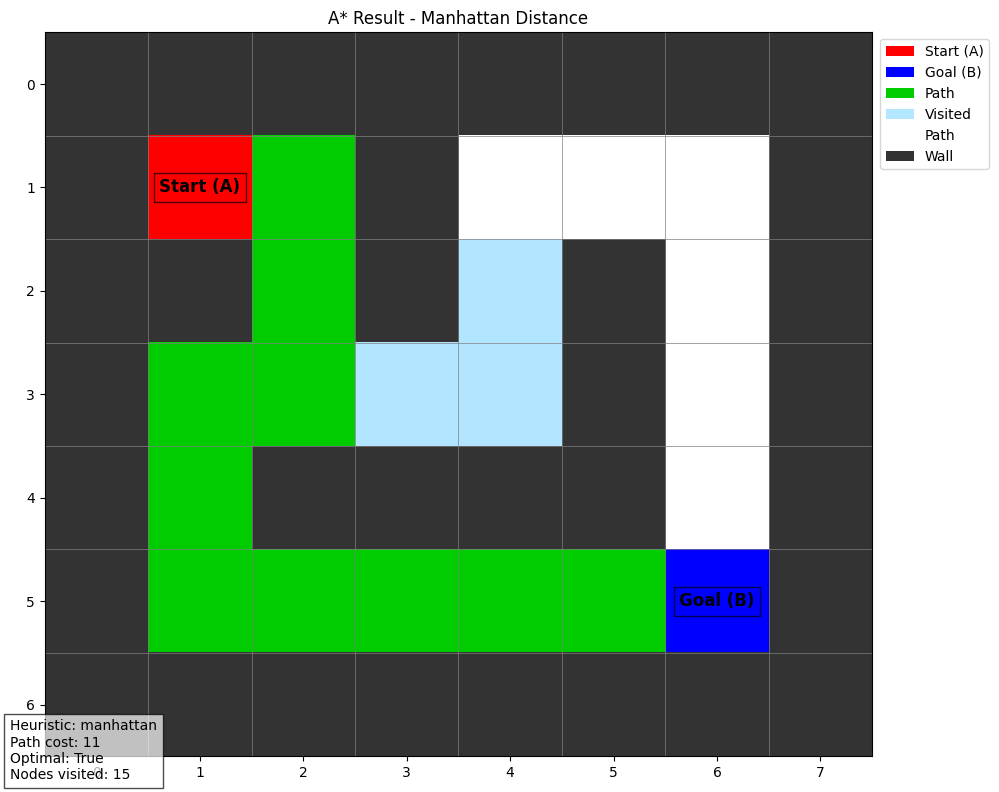

In [37]:
print("=== Manhattan Distance Heuristic ===")
res1 = solver.search('manhattan')
print("Path Found:", res1['path_found'])
print("Cost:", res1['cost_of_path'])
print("Optimal:", res1['path_is_optimal'])
solver.visualize(res1, "- Manhattan Distance")


=== Case 1 Heuristic (Manhattan × 1.5) ===
Admissible: False
Violations: [((4, 6), 1.5, 1), ((5, 5), 1.5, 1), ((3, 6), 3.0, 2)]
Path Found: True
Cost: 11
Optimal: True


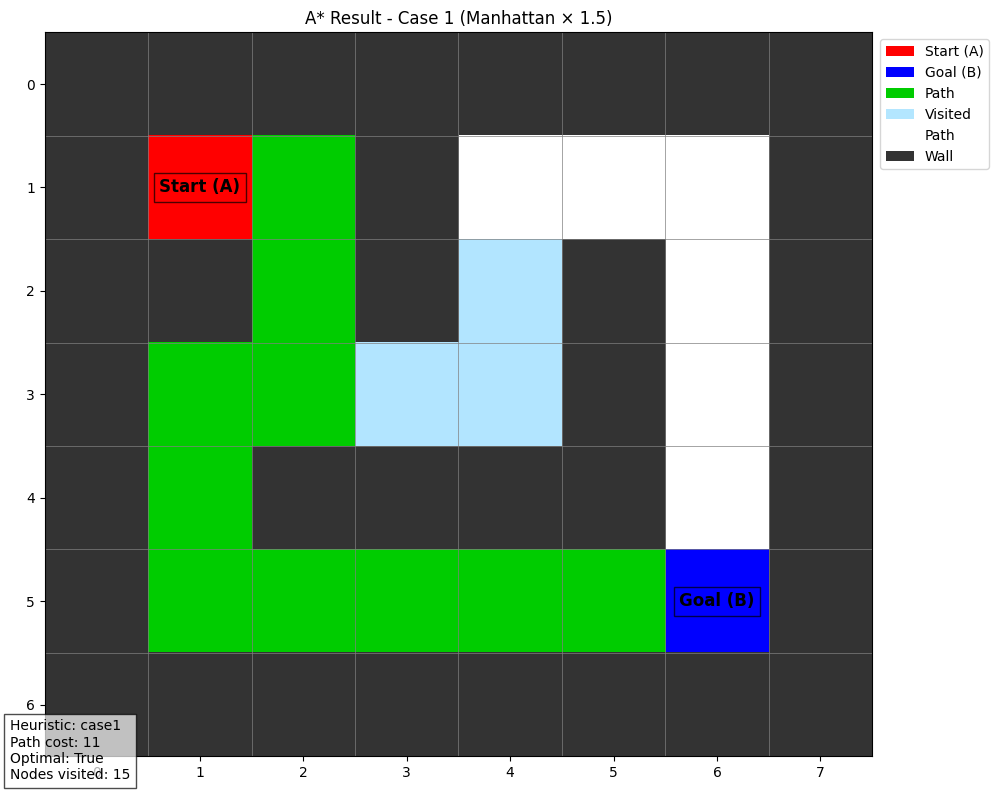

In [38]:
# Run A* with Case 1 heuristic (Manhattan × 1.5)
print("\n=== Case 1 Heuristic (Manhattan × 1.5) ===")
admissible1, violations1 = solver.test_admissibility('case1')
res2 = solver.search('case1')
print("Admissible:", admissible1)
if not admissible1:
    print("Violations:", violations1[:3])  # show first 3 if any
print("Path Found:", res2['path_found'])
print("Cost:", res2['cost_of_path'])
print("Optimal:", res2['path_is_optimal'])
solver.visualize(res2, "- Case 1 (Manhattan × 1.5)")


=== Case 2 Heuristic (Inconsistent) ===
Admissible: False
Violations: [((3, 1), 10, 7)]
Path Found: True
Cost: 13
Optimal: False


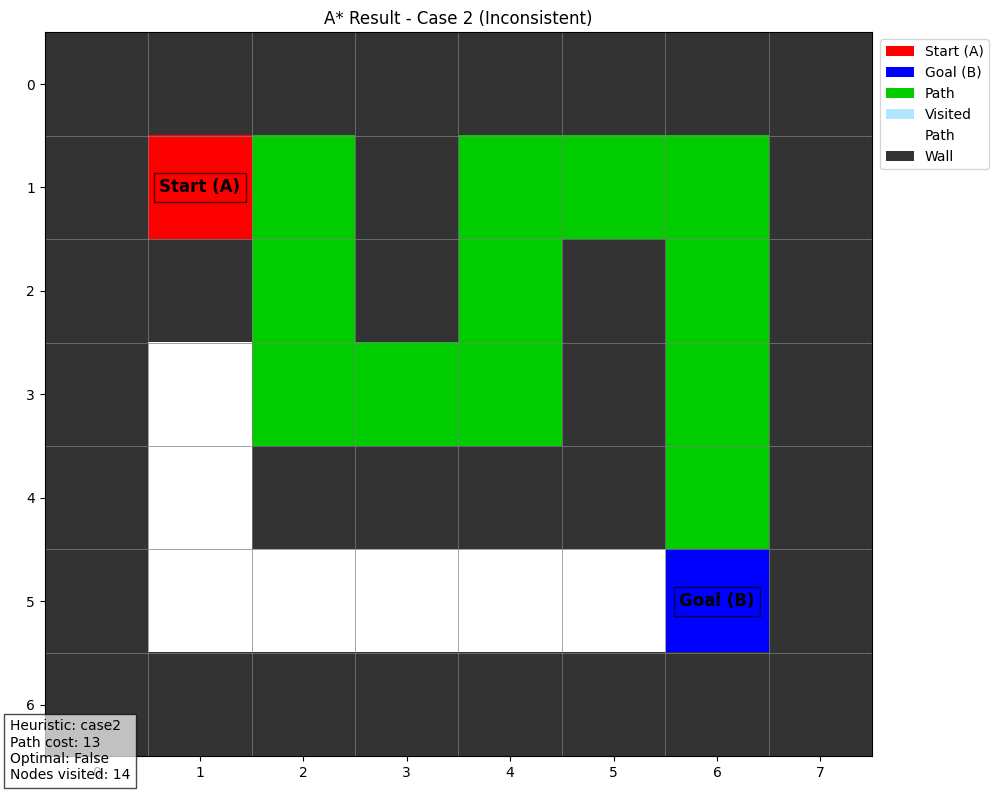

In [39]:
# Run A* with Case 2 heuristic (Inconsistent)
print("\n=== Case 2 Heuristic (Inconsistent) ===")
admissible2, violations2 = solver.test_admissibility('case2')
res3 = solver.search('case2')
print("Admissible:", admissible2)
if not admissible2:
    print("Violations:", violations2[:3])  # show first 3 if any
print("Path Found:", res3['path_found'])
print("Cost:", res3['cost_of_path'])
print("Optimal:", res3['path_is_optimal'])
solver.visualize(res3, "- Case 2 (Inconsistent)")